


<h1><center> User Content Generated Analytics Assignment 1 </center></h1>
<h3> <center> Abhilesh Vikram Gupta, Colin Chu, Stepehen Darasimi Oluwaniyi, Matt Viteri & Yeggi Lee </center></h3>

## Pre-Analysis Tasks

### 0. Word Frequency

In [1]:
import string
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from itertools import combinations, product
from sklearn import manifold
import seaborn as sns
nltk.download('stopwords')

# Removes the punctuation & the stopwords such as "a", "the", and so on
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

[nltk_data] Downloading package stopwords to /Users/ylee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1 & 2. Developing & Deploying the Scraper
Develop a crawler/scraper using Selenium to fetch messages posted in Edmunds.com discussion forums. The crawler output should be a .csv file with the following columns: date, userid, and message (even though you will only use the messages in your analysis). Before you develop the crawler, carefully study one of the forums on Edmunds.com to understand the html as well as the threading structures.

Fetch around 4,000-5000 posts about cars from a General topics forum. Do NOT choose a forum dedicated to a particular brand or model. Instead, you can choose the General & Sedans categories and then select, for example, the Entry Level Luxury forum https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedansThe idea is to have multiple brands and models being discussed without one of them being the focal point. You can choose early or recent posts (do mention what you have chosen). 

#### Results
We developed a scraper called "scrappy" that is accessible via the scrappy folder. The scrapper uses a combination of the libraries scrapy and Beautiful Soup to scrape the following link: 
https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

The scraper scrapes 723 pages with over 20k+ posts which are saved into a csv file for further analysis


In [2]:
## Converts the scrappy csv file into a dataframe
df = pd.read_csv('./scrappy/scrappy_do.csv')
df.head()

,date,userid,message
0,2002-03-25T05:54:02+00:00,merc1,I personally think that with a few tweaks the ...
1,2002-03-25T07:06:29+00:00,fredvh,I am debating a new purchase and these two are...
2,2002-03-25T17:02:27+00:00,blueguydotcom,"Great handling, RWD, excellent engine and the ..."
3,2002-03-25T23:04:37+00:00,hungrywhale,And no manual tranny. That may not matter to y...
4,2002-03-26T00:44:13+00:00,riez,One beauty of BMW 3 Series is that there are s...


### 3. Top 10 Brands by Frequency

Once you fetch the data, find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should not be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. This step is meant to help simplify the analysis. A list of model and brand names (not exhaustive) are provided in a separate file.   

In [3]:
modelsDF = pd.read_csv('./models.csv', names=['make', 'model'])
makemodels = modelsDF[0:520]

def wordCount(post):
    d = {}
    l = str(post).lower().translate(translator).split(" ")
    filtered = [w for w in l if w not in stop_words]
    for w in filtered:
        d[w] = 1 if not d.get(w) else d[w] + 1
    return d

allText = ' '.join(list(map(lambda x: str(x), list(df['message']))))
counts = wordCount(allText)

def extractMakes(wordCounts):
    makes = {}
    for make in makemodels['make']:
        if wordCounts.get(make):
            makes[make] = wordCounts[make]
    return makes

def combineModels(makes, wordCounts):
    for row in makemodels.iterrows():
        make = row[1].make
        model = row[1].model
        if wordCounts.get(model):
            makes[make] += wordCounts.get(model)
    return makes
    
carCounts = combineModels(extractMakes(counts), counts)
carCounts = [(k, v) for k, v in carCounts.items()]
carCounts.sort(key=lambda x: x[1], reverse=True)
display(carCounts)

top10 = list(map(lambda c: c[0], carCounts[0:10]))
print('Top 10: {}'.format(top10))

[('bmw', 11757),
 ('audi', 5879),
 ('acura', 4755),
 ('honda', 3291),
 ('infiniti', 2734),
 ('toyota', 2365),
 ('volkswagen', 1609),
 ('nissan', 1338),
 ('volvo', 1172),
 ('chevrolet', 1063),
 ('mercedes', 996),
 ('ford', 957),
 ('hyundai', 954),
 ('cadillac', 929),
 ('subaru', 744),
 ('mazda', 604),
 ('lincoln', 558),
 ('buick', 475),
 ('dodge', 334),
 ('chrysler', 311),
 ('kia', 274),
 ('pontiac', 257),
 ('mercury', 61),
 ('mitsubishi', 60),
 ('saturn', 47),
 ('suzuki', 44)]

Top 10: ['bmw', 'audi', 'acura', 'honda', 'infiniti', 'toyota', 'volkswagen', 'nissan', 'volvo', 'chevrolet']


In [4]:
# Creates a list of unique model and make values
modelWords = list(modelsDF['make'].unique()) + list(modelsDF['model'].unique())

# Creates a dictionary with models as the key and brands as the value
model_to_make = modelsDF.set_index('model').to_dict(orient='dict')['make']

### Task A.

Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.

Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet).

#### Results: 

The top ten brands are Acura, Audi, BMW, Chevrolet, Honda, Infiniti, Nissan, Toyota, Volkswagen, and Volvo. 


In [5]:
# Removes the punctuation, splits into words, & replaces the model with the make
def splitReplace(post):
    post = str(post).lower()
    
    post = post.translate(translator)
    modelKeys = model_to_make.keys()
    wordList = post.split(' ')
    
    for idx, word in enumerate(wordList):
        if word in modelKeys:
            wordList[idx] = model_to_make.get(word)
            
    unique = list(set(wordList))
    return unique if len(unique) else []

df['words'] = df['message'].map(lambda x: splitReplace(x))

In [6]:
# Calculation of lift scores
def do_lift(x, y=None):
    l1, l2 = sorted(x), sorted(y or [])
    bools = pd.DataFrame()
    for e in l1 + l2:
        bools[e] = df['words'].map(lambda words: e in words)

    def do(df, a, b):
        count_a_int_b = np.logical_and(df[a], df[b]).values.sum()
        count_a_mult_count_b = df[a].values.sum() * df[b].values.sum()
        return len(df.index) * count_a_int_b / count_a_mult_count_b

    result_df = pd.DataFrame(index=l1, columns=(l2 or l1))
    for a, b in (combinations(l1, 2) if y==None else product(l1, l2)):
        val = do(bools, a, b)
        result_df.at[a, b] = val
        if y==None:
            result_df.at[b, a] = val

    return result_df

In [7]:
# List of the top 10 brands
top_10_brands = do_lift(top10)
topBrandsList = list(top_10_brands.columns)
print('The top ten brands are:', topBrandsList)

The top ten brands are: ['acura', 'audi', 'bmw', 'chevrolet', 'honda', 'infiniti', 'nissan', 'toyota', 'volkswagen', 'volvo']


In [8]:
# Dataframe of the top 10 brands
# Darker blues signify larger values and light orange shows the smaller values
floatdf = top_10_brands.astype(float)
np.fill_diagonal(floatdf.values, 0)
floatdf.style.background_gradient(cmap='RdBu')

,acura,audi,bmw,chevrolet,honda,infiniti,nissan,toyota,volkswagen,volvo
acura,0,2.25881,1.35088,1.34404,3.25366,3.17498,1.99418,1.72194,1.72271,2.50784
audi,2.25881,0,1.66233,1.58915,1.71347,2.43379,1.23376,1.57082,3.34349,3.1757
bmw,1.35088,1.66233,0,1.38111,1.18766,1.80204,1.25842,1.4399,1.28244,1.48912
chevrolet,1.34404,1.58915,1.38111,0,1.84124,1.51297,2.77944,2.54244,2.41639,2.01215
honda,3.25366,1.71347,1.18766,1.84124,0,1.50261,3.15628,3.4366,2.37887,1.77878
infiniti,3.17498,2.43379,1.80204,1.51297,1.50261,0,3.46296,1.81368,1.72915,2.53758
nissan,1.99418,1.23376,1.25842,2.77944,3.15628,3.46296,0,4.11521,2.52408,2.0085
toyota,1.72194,1.57082,1.4399,2.54244,3.4366,1.81368,4.11521,0,2.08856,2.26779
volkswagen,1.72271,3.34349,1.28244,2.41639,2.37887,1.72915,2.52408,2.08856,0,2.4455
volvo,2.50784,3.1757,1.48912,2.01215,1.77878,2.53758,2.0085,2.26779,2.4455,0


In [9]:
# Dissimilarity matrix for the MDS plot
dissimilarity_matrix = (1/top_10_brands).astype(float)
np.fill_diagonal(dissimilarity_matrix.values, 0)
dissimilarity_matrix

,acura,audi,bmw,chevrolet,honda,infiniti,nissan,toyota,volkswagen,volvo
acura,0.000000,0.442711,0.740256,0.744028,0.307347,0.314962,0.501460,0.580741,0.580482,0.398750
audi,0.442711,0.000000,0.601564,0.629267,0.583611,0.410882,0.810528,0.636612,0.299089,0.314891
bmw,0.740256,0.601564,0.000000,0.724057,0.841993,0.554926,0.794649,0.694491,0.779764,0.671536
chevrolet,0.744028,0.629267,0.724057,0.000000,0.543113,0.660951,0.359785,0.393323,0.413840,0.496980
honda,0.307347,0.583611,0.841993,0.543113,0.000000,0.665507,0.316828,0.290985,0.420368,0.562185
infiniti,0.314962,0.410882,0.554926,0.660951,0.665507,0.000000,0.288770,0.551364,0.578317,0.394076
nissan,0.501460,0.810528,0.794649,0.359785,0.316828,0.288770,0.000000,0.243001,0.396183,0.497883
toyota,0.580741,0.636612,0.694491,0.393323,0.290985,0.551364,0.243001,0.000000,0.478799,0.440958
volkswagen,0.580482,0.299089,0.779764,0.413840,0.420368,0.578317,0.396183,0.478799,0.000000,0.408914
volvo,0.398750,0.314891,0.671536,0.496980,0.562185,0.394076,0.497883,0.440958,0.408914,0.000000


In [10]:
# Plotting MDS plot
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

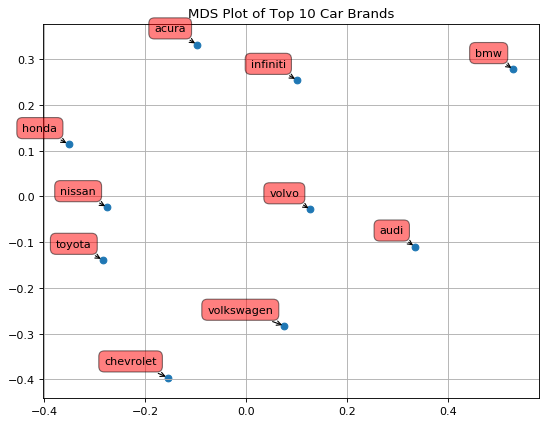

In [11]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(bottom = 0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')

for label, x, y in zip(topBrandsList, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.title('MDS Plot of Top 10 Car Brands')
plt.grid()
plt.show()

## Task B
What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 
- BMW has the highest dissimilarity score across all the brands. This essentially means that the BMW market is more isolated than any other brand. Additionally, as shown in the figure above, Honda, Nissan, and Toyota form a cluster which implies that these brands are commonly mentioned together. As such, we can conclude that consumers think they're closely related and their markets overlap. 

## Task C
What are 5 most frequently mentioned attributes of cars in the discussions? Note that the same attribute may be described by different words – e.g., pick-up and acceleration may both refer to a more general attribute, “performance”. You have to make suitable replacements. Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.


In [12]:
# Filters out words not in modelWords and grabs their frequency counts
countTuple = [(k, v) for k, v in counts.items()]
filtered = list(filter(lambda x: x[0] not in modelWords, countTuple))

# Sort filtered list and display attributes
filtered.sort(key=lambda x: x[1], reverse=True)
display('Example attributes sorted:', filtered[0:20])

# Chosen desired attributes 
attributes = ['performance', 'luxury', 'power', 'handling', 'speed']
print('Selected attributes are:', attributes)

'Example attributes sorted:'

[('', 16666),
 ('like', 7766),
 ('would', 7030),
 ('one', 7014),
 ('get', 5904),
 ('dont', 5320),
 ('new', 4990),
 ('think', 4869),
 ('tl', 4286),
 ('even', 4142),
 ('much', 3835),
 ('im', 3828),
 ('better', 3791),
 ('good', 3703),
 ('drive', 3654),
 ('well', 3629),
 ('3', 3356),
 ('really', 3291),
 ('know', 3256),
 ('people', 3106)]

Selected attributes are: ['performance', 'luxury', 'power', 'handling', 'speed']


In [13]:
## Finds the lift calculations for the attributes
at_df = do_lift( top10[0:5], attributes)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: #5BC84E' if v else '' for v in is_max]
    
def highlight_min(s):
    is_min = s == s.replace(0, np.nan).min()
    return ['background-color: #E56969' if v else '' for v in is_min]

at_df.style.apply(highlight_max).apply(highlight_min)

,handling,luxury,performance,power,speed
acura,1.6829,2.03727,1.62576,1.85756,1.83004
audi,1.85199,1.89727,1.73898,1.93522,1.84652
bmw,1.79176,1.46202,1.62448,1.62643,1.3359
honda,1.67457,1.97196,1.51231,1.80006,1.95387
infiniti,1.60375,2.08745,1.77225,1.86246,1.55059


#### Results
As shown in the table above, the following brands are leading in these attributes: 
- <b> Handling </b>: Audi
- <b> Luxury:</b> Infiniti
- <b> Performance:</b> Infiniti
- <b> Power: </b>Audi
- <b> Speed: </b> Honda

## Task D
What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive).

1. Product Manager
    - <b>Acura </b>:Consumers are strongly associating Acura with luxury compared to other brands as this is indeed very good, but consumers don't strongly associate the Acura brand with high performance. I will recommend in the current and future releases to focus on parts of the car that contribute to high performance such as improving the suspension or fortifying the brakes as these will contribute to better performance.
    - <b>Audi </b>: Consumers are closely associating the Audi brand with good handling and power but the association of high performance with Audi is among the least when compared to other brands. We recommend investing inn features that will potentially improve the performance of the car.
    - <b>BMW </b>:Across all brands, BMW had high associations with handling which represents that the car does drive very efficiently but had the lowest association with speed. This can mean that they do consider the car very safe since it’s been highly correlated with handling compared to other brands but also not correlated with way BMW picks up speed. A recommendation for the next release models is to introduce a turbo model in the BMWs that can provide higher horsepower or better torque which will ultimately increase speed
    - <b>Honda </b>:After the brand analysis with Honda vs other brands, the data shows that consumers associate Honda the least with high performance and the second lowest with good handling in relation to other brands. Handling and performance are very closely correlated and thus Honda should focus on improving its handling which can also see an increase in the positive association between Honda and its performance.
    - <b>Infiniti </b>:With the top brand analysis with infinity vs other brands, we noticed the infinity brand is the least correlated with handling. In other words, compared to other brands, consumers are not strongly associating the brand with how great the handling of infinity is. A recommendation will be to tighten the suspension which will increase handling. A trade off in tightening the suspensions is the ride comfort of the car will be negatively affected which will negatively impact the high positive correlation of the infinity brand with handling and luxury. Our recommendation will be to only very slightly tighten the suspension or modifying the shock absorbers


2. Marketing/Advertising Manager
    - <b> Acura </b>: People are associating Acura with luxury now and it is time to capitalize on that. We should call in high-profile celebrities to reinforce this image and continue this association
    - <b>Audi </b>: Audi is leading in terms of handling and power. We should market that our product allows for fast accelerating yet smooth sailing. It'd be useful to market this towards people that want a fast yet easy to control car. 
    - <b>BMW </b>: BMW is already established as a well-known and regarded luxury brand. It's time to focus more on the safety aspect of the product. We should market the BMW as not only a luxurious brand car but also a safe one that can keep your children and yourself safe when you're driving. 
    - <b>Honda </b>: Honda has high scores on luxury, power and speed meaning that people already associate Honda as one of the top brands for these attributes. We should market this towards successful bachelors as they would would want a car they can show off and enjoy driving . 
    - <b>Infiniti </b>: Infiniti has high scores on luxury, performance and power so we should market this towards people that want an efficient yet luxurious car such as businessmen. 

## Task E 

Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [14]:
aspire = do_lift(top10[0:5], ['love', 'aspire', 'want', 'dream', 'wish'] + ['desire'])

In [15]:
floatasp = aspire.astype(float)
floatasp.style.background_gradient(cmap='Blues')

,aspire,desire,dream,love,want,wish
acura,1.78085,1.36289,1.31374,1.87146,1.51717,1.34805
audi,3.79012,2.10953,2.11818,2.05819,1.86406,1.92183
bmw,2.46141,1.66211,2.07689,1.59364,1.61774,1.57191
honda,2.34205,1.6729,1.15183,1.89126,1.57382,1.5396
infiniti,2.67292,0.954614,1.31455,1.99582,1.79615,2.02332


#### Results

As shown in the table, the most aspirational brand is Audi out of the top 5 brands. For our analysis, we calculated the lift based on the following words: love, aspire, want, dream, desire and wish. We assumed that when people use these words it's in the contexts of having this brand of car as their dream car.

Clearly, this means that Audi is the most desired brand. This could mean that Audi has a strong following and that they could potentially increase their prices 

From a business perspective, the implications could lead to Audi creating different models of audi that target different groups of consumers. For example Entry level Audi vs Super luxury Audi.
